In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import nltk
import math
import time
import re
import os
import seaborn as sns
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import time
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('winemagdata-130k')
data.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
data.shape

(129971, 14)

In [4]:
data = data.loc[:,['description','designation','country','title','variety','price','winery']]
data.shape

(129971, 7)

In [5]:
data['description'].describe()

count                                                129971
unique                                               119955
top       This zesty red has pretty aromas that suggest ...
freq                                                      3
Name: description, dtype: object

In [6]:
data['title'].describe()

count                                                129971
unique                                               118840
top       Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...
freq                                                     11
Name: title, dtype: object

In [7]:
data['variety'].describe()

count         129970
unique           707
top       Pinot Noir
freq           13272
Name: variety, dtype: object

In [8]:
data['country'].describe()

count     129908
unique        43
top           US
freq       54504
Name: country, dtype: object

In [9]:
data['designation'].describe()

count       92506
unique      37979
top       Reserve
freq         2009
Name: designation, dtype: object

In [10]:
data['winery'].describe()

count                 129971
unique                 16757
top       Wines & Winemakers
freq                     222
Name: winery, dtype: object

In [11]:
data['title'].describe()

count                                                129971
unique                                               118840
top       Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...
freq                                                     11
Name: title, dtype: object

In [12]:
country_null = data.loc[data['country'].isnull()]
desig_null = data.loc[data['designation'].isnull()]
variety_null = data.loc[data['variety'].isnull()]
price_null = data.loc[data['price'].isnull()]

print(country_null.shape[0]/129971 *100,'% of data points where country is null')
print(desig_null.shape[0]/129971 *100,'% of data points where designation is null')
print(variety_null.shape[0]/129971 *100,'% of data points where variety is null')
print(price_null.shape[0]/129971 *100,'% of data points where price is null')


0.04847235152457087 % of data points where country is null
28.825661109016625 % of data points where designation is null
0.0007694024051519185 % of data points where variety is null
6.921544036746659 % of data points where price is null


In [13]:
data = data.loc[~data['variety'].isnull()]
print('Number of data points After eliminating variety=NULL :', data.shape[0])

Number of data points After eliminating variety=NULL : 129970


In [14]:
data = data.loc[~data['country'].isnull()]
print('Number of data points After eliminating country=NULL :', data.shape[0])

Number of data points After eliminating country=NULL : 129907


In [15]:
data =data.loc[~data['designation'].isnull()]
print('Number of data points After eliminating designation = NULL :', data.shape[0])

Number of data points After eliminating designation = NULL : 92454


In [16]:
data = data.loc[~data['price'].isnull()]
print('Number of data points After eliminating price = NULL :', data.shape[0])


Number of data points After eliminating price = NULL : 86148


In [17]:
print(86148/129971 *100 ,"% of data remained after eliminating null values")

66.28247839902748 % of data remained after eliminating null values


In [18]:
data.head()

,description,designation,country,title,variety,price,winery
1,"This is ripe and fruity, a wine that is smooth...",Avidagos,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,15.0,Quinta dos Avidagos
3,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,US,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,13.0,St. Julian
4,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,US,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,65.0,Sweet Cheeks
5,Blackberry and raspberry aromas show a typical...,Ars In Vitro,Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,15.0,Tandem
6,"Here's a bright, informal red that opens with ...",Belsito,Italy,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,16.0,Terre di Giurfo


In [19]:
dup_description = sum(data.duplicated('description'))
dup_title =  sum(data.duplicated('title'))
print(dup_description)
print(dup_title)

6671
7429


In [20]:
dup_desc = data.duplicated('description')
dup = pd.DataFrame(dup_desc)
print(type(dup))
dup.head()
dup.columns = ['bool']    
dup.head()

<class 'pandas.core.frame.DataFrame'>


,bool
1,False
3,False
4,False
5,False
6,False


In [21]:
index = dup.loc[dup['bool'] == True]
index

,bool
2409,True
2410,True
2412,True
2413,True
2694,True
3431,True
3432,True
3433,True
4093,True
4094,True


In [26]:
for i in index.iterrows():
    data = data.drop(i[0])

In [27]:
data.shape

(79477, 7)

In [28]:
dup_title = data.duplicated('title')
dup_title = pd.DataFrame(dup_title)
dup_title.columns = ['bool']    
dup_title.head()
indx = dup_title.loc[dup_title['bool'] == True]
for i in indx.iterrows():
    data = data.drop(i[0])
    

In [29]:
data.shape

(78708, 7)

In [30]:
data.to_pickle('pickels/data_dedupe')

In [22]:
data = pd.read_pickle('pickels/data_dedupe')

In [23]:
data['description'].head()

1    This is ripe and fruity, a wine that is smooth...
3    Pineapple rind, lemon pith and orange blossom ...
4    Much like the regular bottling from 2012, this...
5    Blackberry and raspberry aromas show a typical...
6    Here's a bright, informal red that opens with ...
Name: description, dtype: object

In [24]:
data.shape

(78708, 7)

In [25]:
c = data['variety'].value_counts()
c.tail(20)

Petit Courbu                   1
Greco Bianco                   1
Gragnano                       1
Cabernet Franc-Lemberger       1
Groppello                      1
Gelber Traminer                1
Syrah-Carignan                 1
Caprettone                     1
Babosa Negro                   1
Rosenmuskateller               1
Torbato                        1
Tinta Miúda                    1
Cabernet Sauvignon Grenache    1
Zlahtina                       1
Syrah-Grenache-Viognier        1
Schwartzriesling               1
Sideritis                      1
Clairette                      1
Chardonnay-Pinot Gris          1
Diamond                        1
Name: variety, dtype: int64

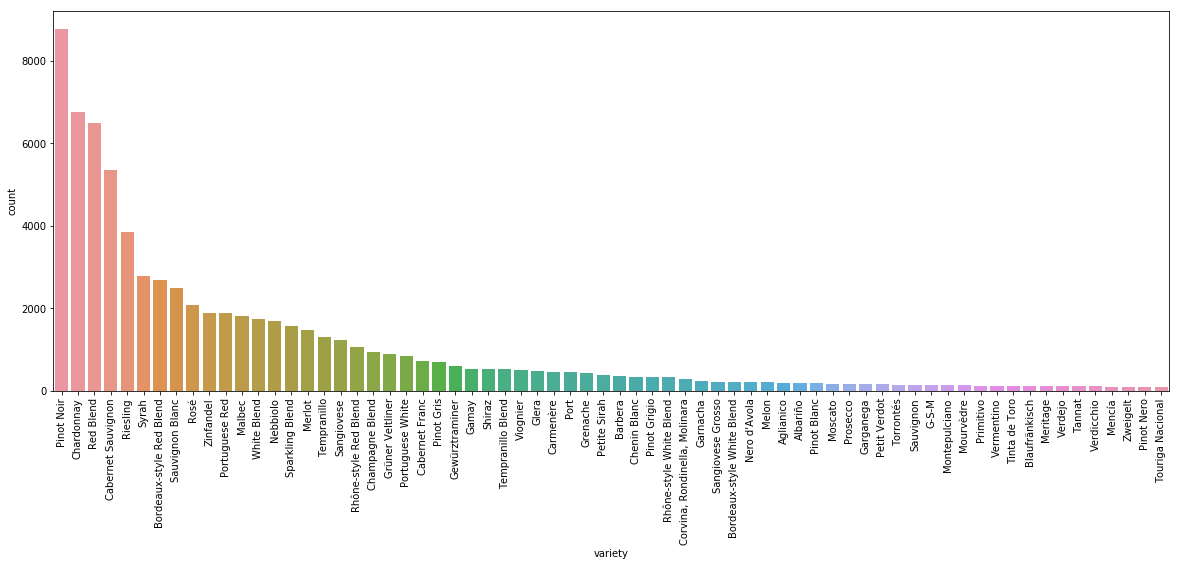

In [26]:
data = data.groupby('variety').filter(lambda x: len(x) >100)
list = data.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=data, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

In [27]:
data['description'].head()

1    This is ripe and fruity, a wine that is smooth...
3    Pineapple rind, lemon pith and orange blossom ...
4    Much like the regular bottling from 2012, this...
8    Savory dried thyme notes accent sunnier flavor...
9    This has great depth of flavor with its fresh ...
Name: description, dtype: object

In [28]:
g=data.groupby('variety')
data = g.filter(lambda x: len(x) > 100)
data['variety'].describe()

count          72276
unique            68
top       Pinot Noir
freq            8779
Name: variety, dtype: object

In [29]:
target = pd.DataFrame(data['variety'])
target.columns = ['variety']
data = data.drop('variety',axis=1)
print(target.head())
print(data.columns)

          variety
1  Portuguese Red
3        Riesling
4      Pinot Noir
8  Gewürztraminer
9      Pinot Gris
Index(['description', 'designation', 'country', 'title', 'price', 'winery'], dtype='object')


In [30]:
target.shape

(72276, 1)

In [37]:
target.to_pickle('pickels/target')

In [2]:
target = pd.read_pickle('pickels/target')


In [4]:
'''red_wines = {'cabernet_sauvignon','shiraz','merlot','pinot_noir','grenache','red_blend','portuguese_red',
             'barbera','zinfandel','montepulciano','valpolicella','barbaresco','bardolino','beaujolais','schicava',
            'gamay','garnacha','cabernet_franc','valpolicella_blend','menc_a','sangiovese','negroamaro','carmen_re',
            'g_s_m','rh_ne_style_red_blend','montepulciano','tempranillo','mourv_dre','malbec','nebbiolo','nero_d_avola',
            'aglianico','bordeaux_style_red_blend','syrah','petit_verdot','touriga_nacional','petite_sirah','tannat','port',
            'primitivo','sangiovese_grosso','tempranillo_blend','tinta_de_toro','zweigelt','blaufr_nkisch',
             'corvina__rondinella__molinara'}
white_wines = {'albari_o','aligote','auslese','chenin_blanc','sauvignon','verdelho','semillon','chardonnay','riesling',
               'pinot_gris','pinot_grigio','white_blend','blanc_e_blancs','garganega','pinot_blanc','pinot_grigio',
               'verdicchio','gr_ner_veltliner','sauvignon_blanc','verdejo','vermentino','viognier','gew_rztraminer',
               'torrontés','bordeaux_style_white_blend','rh_ne_style_white_blend','melon','meritage','moscato',
               'portuguese_white','torront_s'}
sparkling_wines = {'champagne','sparkling_white','sparkling_red','sparkling_rose','sparkling_blend','asti_spumante',
                   'champagne_blend','glera','prosecco'}
rose_wines = {'ros_','pinot_nero'}
def converting(total_text, index, column):
    string = ""
    # replace evershoy special char with space
    total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
    # replace multiple spaces with single space
    total_text = re.sub('\s','_', total_text)
    # converting all the chars into lower-case.
    total_text = total_text.lower()
    for words in total_text.split():

        if words in red_wines:
            words = 'red_wines'
            string += words
        elif words in white_wines:
            words = 'white_wines'
            string += words
        elif words in sparkling_wines:
            words = 'sparkling_wines'
            string += words
        elif words in rose_wines:
            words = 'rose_wines'
            string += words
        else:
            string += words
    target[column][index] = string
for index, row in target.iterrows():
    converting(row['variety'], index, 'variety')   '''  

'red_wines = {\'cabernet_sauvignon\',\'shiraz\',\'merlot\',\'pinot_noir\',\'grenache\',\'red_blend\',\'portuguese_red\',\n             \'barbera\',\'zinfandel\',\'montepulciano\',\'valpolicella\',\'barbaresco\',\'bardolino\',\'beaujolais\',\'schicava\',\n            \'gamay\',\'garnacha\',\'cabernet_franc\',\'valpolicella_blend\',\'menc_a\',\'sangiovese\',\'negroamaro\',\'carmen_re\',\n            \'g_s_m\',\'rh_ne_style_red_blend\',\'montepulciano\',\'tempranillo\',\'mourv_dre\',\'malbec\',\'nebbiolo\',\'nero_d_avola\',\n            \'aglianico\',\'bordeaux_style_red_blend\',\'syrah\',\'petit_verdot\',\'touriga_nacional\',\'petite_sirah\',\'tannat\',\'port\',\n            \'primitivo\',\'sangiovese_grosso\',\'tempranillo_blend\',\'tinta_de_toro\',\'zweigelt\',\'blaufr_nkisch\',\n             \'corvina__rondinella__molinara\'}\nwhite_wines = {\'albari_o\',\'aligote\',\'auslese\',\'chenin_blanc\',\'sauvignon\',\'verdelho\',\'semillon\',\'chardonnay\',\'riesling\',\n               \'pino

In [32]:
from wordcloud import WordCloud
freq=df[df['price']>=65]

wordcloud = WordCloud(width = 1000, height = 500, background_color='black').generate(' '.join(freq['description']))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)

plt.axis("off")

plt.title('Most frequent words useed to describe top rated wines')
# see thz can i add most freuent wrds in tht blog.?

ModuleNotFoundError: No module named 'wordcloud'

In [33]:
Counter(target['variety'])

Counter({'Aglianico': 200,
         'Albariño': 199,
         'Barbera': 357,
         'Blaufränkisch': 127,
         'Bordeaux-style Red Blend': 2692,
         'Bordeaux-style White Blend': 226,
         'Cabernet Franc': 725,
         'Cabernet Sauvignon': 5350,
         'Carmenère': 458,
         'Champagne Blend': 953,
         'Chardonnay': 6757,
         'Chenin Blanc': 345,
         'Corvina, Rondinella, Molinara': 296,
         'G-S-M': 138,
         'Gamay': 537,
         'Garganega': 160,
         'Garnacha': 234,
         'Gewürztraminer': 612,
         'Glera': 494,
         'Grenache': 439,
         'Grüner Veltliner': 896,
         'Malbec': 1813,
         'Melon': 213,
         'Mencía': 110,
         'Meritage': 125,
         'Merlot': 1491,
         'Montepulciano': 136,
         'Moscato': 169,
         'Mourvèdre': 135,
         'Nebbiolo': 1708,
         "Nero d'Avola": 216,
         'Petit Verdot': 159,
         'Petite Sirah': 390,
         'Pinot Blanc': 190,
   

In [33]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'not', 'an', 'other', 'mightn', 'didn', 'myself', 'was', 'are', 'very', 'be', 'during', 'over', 'only', 'we', 'both', 'have', 'which', 'his', 'its', 'them', 'against', 'ma', 'after', 'more', 'most', 'won', 'your', 'do', 'you', 'o', 'isn', 'so', 'has', 'shan', 'own', 'couldn', 'their', 'my', 'yours', 'nor', 'is', 'when', 'by', 'each', 'm', 'am', 'don', 'd', 'in', 'further', 'all', 'these', 'does', 'ain', 'weren', 're', 'haven', 'hers', 'he', 'did', 'ours', 'hasn', 'himself', 'she', 'having', 'for', 'once', 'they', 'can', 'wasn', 'theirs', 'ourselves', 'under', 'hadn', 'too', 'any', 'no', 'before', 'shouldn', 'through', 't', 'yourself', 'those', 'had', 'needn', 'because', 'at', 'been', 'to', 'just', 'our', 'who', 'him', 'yourselves', 'should', 'same', 'then', 'and', 've', 'that', 'y', 'were', 'where', 'doesn', 'while', 'as', 'down', 'out', 'how', 'above', 'again', 'until', 'there', 'why', 'herself', 'it', 'here', 'some', 'will', 'i', 'itself', 'of', 'her', 'from', 'b

In [34]:
import time
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['description'], index, 'description')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

10879.265836138378 seconds


In [8]:
data.to_pickle('pickels/after_stopwrds')

In [3]:
data = pd.read_pickle('pickels/after_stopwrds')

In [4]:
data.shape

(72276, 6)

In [5]:
data['description'].head()

1    ripe fruity wine smooth still structured firm ...
3    pineapple rind lemon pith orange blossom start...
4    much like regular bottling 2012 comes across r...
8    savory dried thyme notes accent sunnier flavor...
9    great depth flavor fresh apple pear fruits tou...
Name: description, dtype: object

In [6]:
target['variety'] = target['variety'].astype('category')
cat_columns = target.select_dtypes(['category']).columns
target[cat_columns] = target[cat_columns].apply(lambda x: x.cat.codes)
Counter(target['variety'])

Counter({0: 200,
         1: 199,
         2: 357,
         3: 127,
         4: 2692,
         5: 226,
         6: 725,
         7: 5350,
         8: 458,
         9: 953,
         10: 6757,
         11: 345,
         12: 296,
         13: 138,
         14: 537,
         15: 160,
         16: 234,
         17: 612,
         18: 494,
         19: 439,
         20: 896,
         21: 1813,
         22: 213,
         23: 110,
         24: 125,
         25: 1491,
         26: 136,
         27: 169,
         28: 135,
         29: 1708,
         30: 216,
         31: 159,
         32: 390,
         33: 190,
         34: 339,
         35: 703,
         36: 102,
         37: 8779,
         38: 454,
         39: 1892,
         40: 841,
         41: 133,
         42: 162,
         43: 6503,
         44: 1071,
         45: 330,
         46: 3857,
         47: 2086,
         48: 1248,
         49: 229,
         50: 147,
         51: 2496,
         52: 531,
         53: 1565,
         54: 2785,
    

In [9]:
# DONT COPY ME :-p see abve the classes
# use f1scroe or something
# what is the error metric used in that kaggle? THEY USED THT ACCURACY MEASURE SIMPLE

In [11]:

X_train, test_df, y_train, y_test = train_test_split(data,target, stratify=target, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [12]:
print(train_df.shape)
print(cv_df.shape)
print(test_df.shape)

(46256, 6)
(11564, 6)
(14456, 6)


In [13]:
desc_vectorizer = CountVectorizer()
train_description_feature_onehotCoding = desc_vectorizer.fit_transform(train_df['description'])
test_description_feature_onehotCoding = desc_vectorizer.transform(test_df['description'])
cv_description_feature_onehotCoding = desc_vectorizer.transform(cv_df['description'])

In [83]:
train_description_feature_onehotCoding.shape

(46256, 29642)

In [84]:
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
train_description_feature_ngrams = desc_vectorizer.fit_transform(train_df['description'])
test_description_feature_ngrams = desc_vectorizer.transform(test_df['description'])
cv_description_feature_ngrams = desc_vectorizer.transform(cv_df['description'])

In [85]:
tfidf_description_vectorizer = TfidfVectorizer(min_df = 0)
train_description_feature_tfidf = tfidf_description_vectorizer.fit_transform(train_df['description'])
test_description_feature_tfidf = tfidf_description_vectorizer.transform(test_df['description'])
cv_description_feature_tfidf = tfidf_description_vectorizer.transform(cv_df['description'])

In [86]:
train_description_feature_tfidf.shape

(46256, 29642)

In [ ]:
#i USED that calibrated clasifer in each algo>>>i hve to chnge tht all and rerun>>?
# check with one model and then see ..ohk
# till it cmplete tell mee......u saw tht profile..?

For values of alpha =  1e-05 The accuracy  is: 0.578951919751
For values of alpha =  0.0001 The accuracy  is: 0.628675198893
For values of alpha =  0.001 The accuracy  is: 0.572985126254
For values of alpha =  0.01 The accuracy  is: 0.437218955379
For values of alpha =  0.1 The accuracy  is: 0.328260117606
For values of alpha =  1 The accuracy  is: 0.273607748184


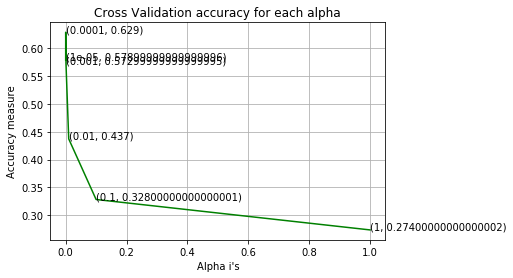

For values of best alpha =  0.0001 The train accuracy is: 0.795204946385
For values of best alpha =  0.0001 The cross validation accuracy is: 0.628675198893
For values of best alpha =  0.0001 The test accuracy is: 0.626591034864


In [15]:
alpha = [10 ** x for x in range(-5, 1)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_description_feature_onehotCoding, y_train)
    
    
    predict_y = clf.predict(cv_description_feature_onehotCoding)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy  is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_description_feature_onehotCoding, y_train)


predict_y = clf.predict(train_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = clf.predict(cv_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = clf.predict(test_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))
# same as prev

For values of alpha =  1e-05 The accuracy  is: 0.568834313386
For values of alpha =  0.0001 The accuracy  is: 0.606191629194
For values of alpha =  0.001 The accuracy  is: 0.623573158077
For values of alpha =  0.01 The accuracy  is: 0.529401591145
For values of alpha =  0.1 The accuracy  is: 0.402282947077
For values of alpha =  1 The accuracy  is: 0.325492909028


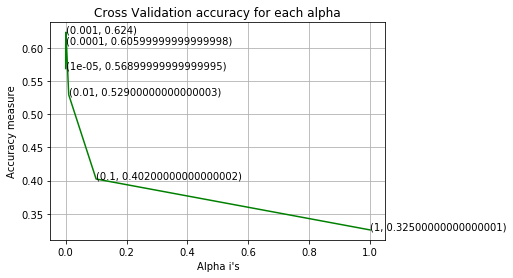

For values of best alpha =  0.001 The train accuracy is: 0.728640608786
For values of best alpha =  0.001 The cross validation accuracy is: 0.623573158077
For values of best alpha =  0.001 The test accuracy is: 0.619050913116


In [16]:
alpha = [10 ** x for x in range(-5, 1)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_description_feature_onehotCoding, y_train)
    
    
    predict_y = clf.predict(cv_description_feature_onehotCoding)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy  is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_description_feature_onehotCoding, y_train)


predict_y = clf.predict(train_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = clf.predict(cv_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = clf.predict(test_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))

For values of alpha =  1e-05 The accuracy loss is: 0.610601867866
For values of alpha =  0.0001 The accuracy loss is: 0.634469041854
For values of alpha =  0.001 The accuracy loss is: 0.6270321688
For values of alpha =  0.01 The accuracy loss is: 0.504842615012
For values of alpha =  0.1 The accuracy loss is: 0.324801106883
For values of alpha =  1 The accuracy loss is: 0.151937046005


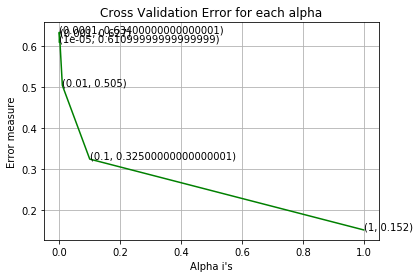

For values of best alpha =  0.0001 The train accuracy is: 0.839393808371
For values of best alpha =  0.0001 The cross validation accuracy is: 0.634469041854
For values of best alpha =  0.0001 The test accuracy is: 0.621057000553


In [68]:
alpha = [10 ** x for x in range(-5, 1)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_description_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_description_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict(cv_description_feature_onehotCoding)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy loss is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_description_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_description_feature_onehotCoding, y_train)

predict_y = sig_clf.predict(train_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))

For values of alpha =  1e-05 The accuracy loss is: 0.648478035282
For values of alpha =  0.0001 The accuracy loss is: 0.640349360083
For values of alpha =  0.001 The accuracy loss is: 0.62789692148
For values of alpha =  0.01 The accuracy loss is: 0.615703908682
For values of alpha =  0.1 The accuracy loss is: 0.194742303701
For values of alpha =  1 The accuracy loss is: 0.183414043584


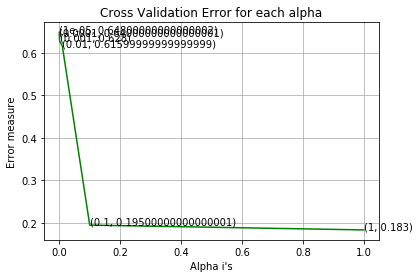

For values of best alpha =  1e-05 The train accuracy is: 0.906282428226
For values of best alpha =  1e-05 The cross validation accuracy is: 0.648478035282
For values of best alpha =  1e-05 The test accuracy is: 0.636275594909


In [69]:
alpha = [10 ** x for x in range(-5, 1)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_description_feature_tfidf, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_description_feature_tfidf, y_train)
    predict_y = sig_clf.predict(cv_description_feature_tfidf)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy loss is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_description_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_description_feature_tfidf, y_train)

predict_y = sig_clf.predict(train_description_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_description_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_description_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))


for alpha = 1e-05
accuracy : 0.495157384988
for alpha = 0.0001
accuracy : 0.511155309581
for alpha = 0.001
accuracy : 0.526288481494
for alpha = 0.1
accuracy : 0.551106883431
for alpha = 1
accuracy : 0.472327914217
for alpha = 10
accuracy : 0.350397786233
for alpha = 100
accuracy : 0.335696990661
for alpha = 1000
accuracy : 0.342182635766


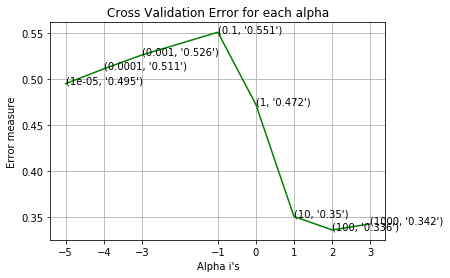

For values of best alpha =  0.1 The train accuracy is: 0.761760636458
For values of best alpha =  0.1 The cross validation accuracy is: 0.551106883431
For values of best alpha =  0.1 The test accuracy is: 0.547315993359


In [65]:
from sklearn.naive_bayes import MultinomialNB
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_accuracy_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_description_feature_onehotCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_description_feature_onehotCoding,y_train)
    sig_clf_probs = sig_clf.predict(cv_description_feature_onehotCoding)
    cv_accuracy_array.append(accuracy_score(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("accuracy :",accuracy_score(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_accuracy_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_description_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_description_feature_onehotCoding, y_train)


predict_y = sig_clf.predict(train_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_description_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))


for alpha = 1e-05
accuracy : 0.464718090626
for alpha = 0.0001
accuracy : 0.482186094777
for alpha = 0.001
accuracy : 0.50492909028
for alpha = 0.1
accuracy : 0.524818401937
for alpha = 1
accuracy : 0.478986509858
for alpha = 10
accuracy : 0.465150466966
for alpha = 100
accuracy : 0.455465236942
for alpha = 1000
accuracy : 0.455897613283


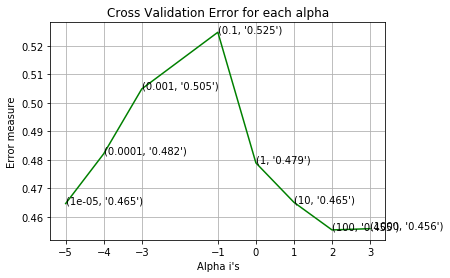

For values of best alpha =  0.1 The train accuracy is: 0.730283638879
For values of best alpha =  0.1 The cross validation accuracy is: 0.524818401937
For values of best alpha =  0.1 The test accuracy is: 0.519853348091


In [67]:
from sklearn.naive_bayes import MultinomialNB
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_accuracy_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_description_feature_tfidf,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_description_feature_tfidf,y_train)
    sig_clf_probs = sig_clf.predict(cv_description_feature_tfidf)
    cv_accuracy_array.append(accuracy_score(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("accuracy :",accuracy_score(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_accuracy_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_description_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_description_feature_tfidf, y_train)


predict_y = sig_clf.predict(train_description_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_description_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_description_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))


In [7]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# merge texts
descriptions = list(data['description'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf_desc_features = tfidf.fit_transform(descriptions)

tfidf_desc_features  = tfidf_desc_features.astype(np.float)

In [18]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : description of the wine
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the tfidf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  tfidf.vocabulary_:
                
                vec.append(tfidf_desc_features[doc_id, tfidf.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    
    vec = np.array(vec)
    vec = vec.mean(axis=0)
    return  vec

In [19]:
vocab = model.keys()
doc_id = 0
w2v_description = []
tfidf_w2v_descr =[]
# for every description we build a avg vector representation
for i in data['description']:
    tfidf_w2v_descr.append(get_word_vec(i,doc_id,'weighted'))
    doc_id += 1
    




In [20]:
data['tfidf_wrd2vec'] = tfidf_w2v_descr

In [56]:
data['wrd2vec'] = w2v_description

In [21]:
data.head()

,description,designation,country,title,price,winery,tfidf_wrd2vec
1,ripe fruity wine smooth still structured firm ...,Avidagos,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),15.0,Quinta dos Avidagos,"[-0.00134130174272, 0.00296340878343, -0.00443..."
3,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,US,St. Julian 2013 Reserve Late Harvest Riesling ...,13.0,St. Julian,"[-0.00479942118926, 0.011564758961, -0.0003151..."
4,much like regular bottling 2012 comes across r...,Vintner's Reserve Wild Child Block,US,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,65.0,Sweet Cheeks,"[0.00522688169731, 0.0101461132802, -0.0048266..."
8,savory dried thyme notes accent sunnier flavor...,Shine,Germany,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,12.0,Heinz Eifel,"[-0.00736149026574, 0.011621412982, -0.0071603..."
9,great depth flavor fresh apple pear fruits tou...,Les Natures,France,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,27.0,Jean-Baptiste Adam,"[-0.000223348926132, 0.0223974450491, 0.000233..."


In [63]:
df = data.drop(['designation','country','title','price','winery','description'],axis=1)
df = pd.DataFrame(data['wrd2vec'].values.tolist(), index= df.index)


In [64]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1,-0.009414,0.017585,-0.030814,0.042966,-0.034119,-0.014154,0.047176,-0.063593,0.027751,0.074998,...,-0.024368,-0.046669,0.014262,-0.034217,0.021626,0.006191,0.032924,-0.027418,0.014082,0.027547
3,-0.019996,0.053089,-0.006533,0.077504,-0.011608,-0.015919,0.074071,-0.122085,0.006487,0.110128,...,-0.061136,-0.036749,-0.041989,-0.089181,0.047131,0.024642,0.002274,0.005979,0.033622,0.065197
4,0.033173,0.042900,-0.023666,0.091482,-0.005512,0.044506,0.045542,-0.081106,0.000179,0.109685,...,-0.060822,-0.002810,-0.024099,0.035229,0.012858,0.003652,0.067935,-0.021953,0.075092,0.057607
8,-0.039658,0.012982,-0.036808,0.096051,0.014149,0.020213,0.057682,-0.047410,-0.002474,0.185949,...,-0.066148,-0.124576,0.027114,-0.003479,0.104945,0.009855,0.087327,-0.065489,0.062407,0.053862
9,-0.000627,0.075138,0.003617,0.059989,-0.039812,0.030343,0.093473,-0.112724,-0.045164,0.166455,...,-0.072827,-0.084782,0.035722,-0.041455,0.015164,-0.019973,-0.006449,-0.042914,0.016949,-0.002238


In [22]:
df2 = data.drop(['designation','country','title','price','winery','description'],axis=1)

In [23]:
df2 = pd.DataFrame(data['tfidf_wrd2vec'].values.tolist(), index= df2.index)

In [24]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1,-0.001341,0.002963,-0.004430,0.006254,-0.007441,-0.004121,0.005817,-0.009468,0.004501,0.013143,...,-0.006067,-0.007126,-0.000629,-0.006001,0.001649,0.003213,0.006112,-0.005280,-0.000955,0.001445
3,-0.004799,0.011565,-0.000315,0.016283,-0.001458,-0.000624,0.014385,-0.024511,-0.001369,0.021458,...,-0.014005,-0.007074,-0.007350,-0.019450,0.009283,0.005510,-0.002391,0.000613,0.007753,0.015970
4,0.005227,0.010146,-0.004827,0.016324,-0.002085,0.006962,0.006676,-0.014905,0.000162,0.018824,...,-0.011633,0.000839,-0.006316,0.005623,0.002504,-0.001024,0.008815,-0.003530,0.015238,0.010120
8,-0.007361,0.011621,-0.007160,0.017879,0.003230,0.003405,0.009326,-0.005410,0.003934,0.037519,...,-0.017755,-0.020070,0.003063,-0.001378,0.021721,0.001979,0.013683,-0.016910,0.008117,0.006520
9,-0.000223,0.022397,0.000233,0.014298,-0.008672,0.006308,0.025374,-0.030139,-0.010834,0.041768,...,-0.020869,-0.022500,0.008465,-0.012644,0.002234,-0.004817,-0.003038,-0.011486,0.002695,-0.002582


In [19]:
df2.shape

(72276, 300)

In [65]:
df.shape

(72276, 300)

In [26]:
X_train, test_df, y_train, y_test = train_test_split(df2,target, stratify=target, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [27]:
train_df.shape

(46256, 300)

For values of alpha =  1e-10 The accuracy loss is: 0.077827741266
For values of alpha =  1e-09 The accuracy loss is: 0.0741957800069
For values of alpha =  1e-08 The accuracy loss is: 0.104808024905
For values of alpha =  1e-07 The accuracy loss is: 0.116655136631
For values of alpha =  1e-06 The accuracy loss is: 0.204427533725
For values of alpha =  1e-05 The accuracy loss is: 0.267468004151
For values of alpha =  0.0001 The accuracy loss is: 0.187391905915
For values of alpha =  0.001 The accuracy loss is: 0.122794880664
For values of alpha =  0.01 The accuracy loss is: 0.121497751643


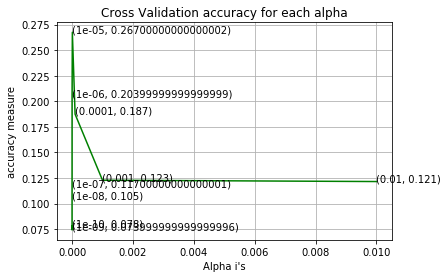

For values of best alpha =  1e-05 The train accuracy is: 0.271964718091
For values of best alpha =  1e-05 The cross validation accuracy is: 0.267468004151
For values of best alpha =  1e-05 The test accuracy is: 0.259753735473


In [29]:
alpha = [10 ** x for x in range(-10, -1)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    
    
    predict_y = clf.predict(cv_df)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy loss is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("accuracy measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)


predict_y = clf.predict(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = clf.predict(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = clf.predict(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))
#simple using wrd2vc
# it is still increasing you can check for other values
# change the label or error matric..ok...see code once again..i chnged little bit

For values of alpha =  1e-10 The accuracy loss is: 0.454427533725
For values of alpha =  1e-09 The accuracy loss is: 0.454168107921
For values of alpha =  1e-08 The accuracy loss is: 0.456502940159
For values of alpha =  1e-07 The accuracy loss is: 0.455205811138
For values of alpha =  1e-06 The accuracy loss is: 0.45511933587


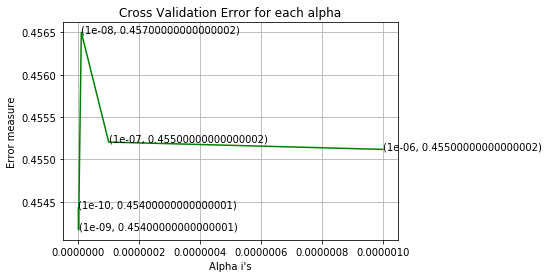

For values of best alpha =  1e-08 The train accuracy is: 0.490617433414
For values of best alpha =  1e-08 The cross validation accuracy is: 0.456502940159
For values of best alpha =  1e-08 The test accuracy is: 0.457042058661


In [71]:
alpha = [10 ** x for x in range(-10, -5)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_df, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    predict_y = sig_clf.predict(cv_df)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy loss is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation Accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))

In [72]:
from sklearn.naive_bayes import MultinomialNB
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_accuracy_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_df,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df,y_train)
    sig_clf_probs = sig_clf.predict(cv_df)
    cv_accuracy_array.append(accuracy_score(y_cv, sig_clf_probs))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("accuracy :",accuracy_score(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_accuracy_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)


predict_y = sig_clf.predict(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))
# what is this....naive bayes naaa..cant run neg valuess..

for alpha = 1e-05


ValueError: Input X must be non-negative

For values of alpha =  1e-10 The accuracy loss is: 0.380058803182
For values of alpha =  1e-09 The accuracy loss is: 0.380404704255
For values of alpha =  1e-08 The accuracy loss is: 0.380058803182
For values of alpha =  1e-07 The accuracy loss is: 0.382307160152
For values of alpha =  1e-06 The accuracy loss is: 0.380664130059


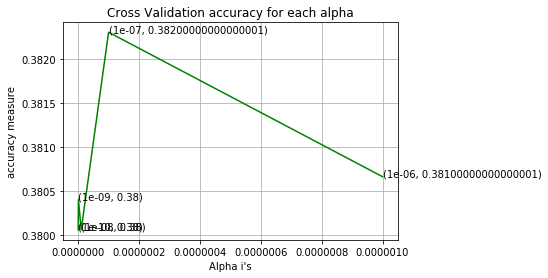

For values of best alpha =  1e-07 The train accuracy is: 0.395019024559
For values of best alpha =  1e-07 The cross validation accuracy is: 0.382307160152
For values of best alpha =  1e-07 The test accuracy is: 0.382125069175


In [21]:
#using tfidf wrd2vec
alpha = [10 ** x for x in range(-10, -5)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    predict_y = sig_clf.predict(cv_df)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy loss is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("accuracy measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))

For values of alpha =  1e-10 The accuracy loss is: 0.375994465583
For values of alpha =  1e-09 The accuracy loss is: 0.374092009685
For values of alpha =  1e-08 The accuracy loss is: 0.375735039779
For values of alpha =  1e-07 The accuracy loss is: 0.376253891387
For values of alpha =  1e-06 The accuracy loss is: 0.3729678312
For values of alpha =  1e-05 The accuracy loss is: 0.370460048426
For values of alpha =  0.0001 The accuracy loss is: 0.37253545486
For values of alpha =  0.001 The accuracy loss is: 0.370892424767
For values of alpha =  0.01 The accuracy loss is: 0.367087512971


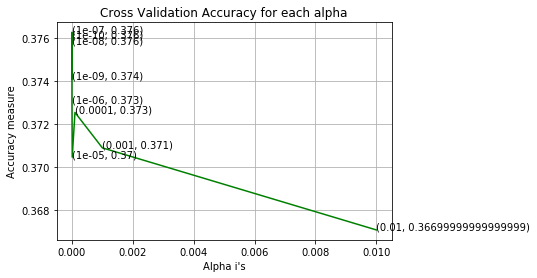

For values of best alpha =  1e-07 The train accuracy is: 0.390976305777
For values of best alpha =  1e-07 The cross validation accuracy is: 0.376253891387
For values of best alpha =  1e-07 The test accuracy is: 0.379911455451


In [22]:
alpha = [10 ** x for x in range(-10, -1)]
cv_accuracy_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_df, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    predict_y = sig_clf.predict(cv_df)
    
    cv_accuracy_array.append(accuracy_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The accuracy loss is:",accuracy_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, cv_accuracy_array,c='g')
for i, txt in enumerate(np.round(cv_accuracy_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_accuracy_array[i]))
plt.grid()
plt.title("Cross Validation Accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()


best_alpha = np.argmax(cv_accuracy_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train accuracy is:",accuracy_score(y_train, predict_y))
predict_y = sig_clf.predict(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation accuracy is:",accuracy_score(y_cv, predict_y))
predict_y = sig_clf.predict(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test accuracy is:",accuracy_score(y_test, predict_y))

In [89]:
token_count = sum([len(list_of_sent) for sentence in list_of_sent])
print('The wine corpus contains {0:,} tokens'.format(token_count))

The wine corpus contains 5,223,820,176 tokens


In [ ]:
import gensim
i=0
list_of_sent=[]
for sent in data['description'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [90]:
import multiprocessing
num_features = 300
min_word_count = 10
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-3
seed=1993

In [91]:
import gensim.models.word2vec as w2v
wine2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [92]:
wine2vec.build_vocab(list_of_sent)
print('Word2Vec vocabulary length:', len(wine2vec.wv.vocab))
print(wine2vec.corpus_count)
wine2vec_model=wine2vec.train(list_of_sent, total_examples=wine2vec.corpus_count, epochs=wine2vec.iter)

Word2Vec vocabulary length: 7176
72276


In [81]:
words = list(wine2vec.wv.vocab)
print(len(words))

7176


In [66]:
wine2vec.most_similar('berry')

[('darkberry', 0.702000617980957),
 ('carmenèreled', 0.6222140192985535),
 ('berryfruit', 0.6157255172729492),
 ('clacky', 0.5929379463195801),
 ('herballeaning', 0.5886809229850769),
 ('transitioning', 0.5870229005813599),
 ('stocky', 0.5867764949798584),
 ('scratchiness', 0.5854229927062988),
 ('wildberry', 0.5840750932693481),
 ('carob', 0.5798763036727905)]

In [202]:
wine2vec.most_similar('melon')

[('papaya', 0.7389829158782959),
 ('cantaloupe', 0.7276902794837952),
 ('honeydew', 0.6906118392944336),
 ('melony', 0.6819292306900024),
 ('mango', 0.6786099672317505),
 ('nectarine', 0.6725907325744629),
 ('buttercup', 0.6706711053848267),
 ('tropicalleaning', 0.6666294932365417),
 ('banana', 0.6614856719970703),
 ('guava', 0.6490943431854248)]